In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [3]:
dataset = torchvision.datasets.MNIST(root=".", download=True, transform=transform, train=True)

In [4]:
len(dataset)

60000

In [5]:
loader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, batch_size=128)

In [6]:
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
)

In [7]:
latent_dims = 100
G = nn.Sequential(
    nn.Linear(latent_dims, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = D.to(device)
G = G.to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
def scale_image(img):
    out = (img + 1)/2
    return out

In [11]:
if not os.path.exists("gan_images"):
    os.makedirs("gan_images")

In [12]:
batch_size = 128
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

d_losses = []
g_losses = []

for epoch in range(200):
    for inputs, _ in loader:
        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)

        ones = ones_[:n]
        zeros = zeros_[:n]

        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)

        noise = torch.randn(n, latent_dims).to(device)
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        d_loss_fake = criterion(fake_outputs, zeros)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        for _ in range(2):
            noise = torch.randn(n, latent_dims).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)

            g_loss = criterion(fake_outputs, ones)

            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
    
    print(f"Epoch: {epoch}/200, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0/200, d_loss: 0.6822711229324341, g_loss: 0.7164568901062012
Epoch: 1/200, d_loss: 0.6698476076126099, g_loss: 0.7266301512718201
Epoch: 2/200, d_loss: 0.6540367007255554, g_loss: 0.762763261795044
Epoch: 3/200, d_loss: 0.6746183633804321, g_loss: 0.7216423749923706
Epoch: 4/200, d_loss: 0.688659131526947, g_loss: 0.7229568362236023
Epoch: 5/200, d_loss: 0.6858590245246887, g_loss: 0.6927001476287842
Epoch: 6/200, d_loss: 0.6984195113182068, g_loss: 0.6938724517822266
Epoch: 7/200, d_loss: 0.6879826784133911, g_loss: 0.7219898104667664
Epoch: 8/200, d_loss: 0.6844522953033447, g_loss: 0.734886884689331
Epoch: 9/200, d_loss: 0.6979373693466187, g_loss: 0.7027310729026794
Epoch: 10/200, d_loss: 0.6843885779380798, g_loss: 0.6925876140594482
Epoch: 11/200, d_loss: 0.6862941980361938, g_loss: 0.6980039477348328
Epoch: 12/200, d_loss: 0.686726987361908, g_loss: 0.7080159187316895
Epoch: 13/200, d_loss: 0.6858071088790894, g_loss: 0.7436723113059998
Epoch: 14/200, d_loss: 0.686500430

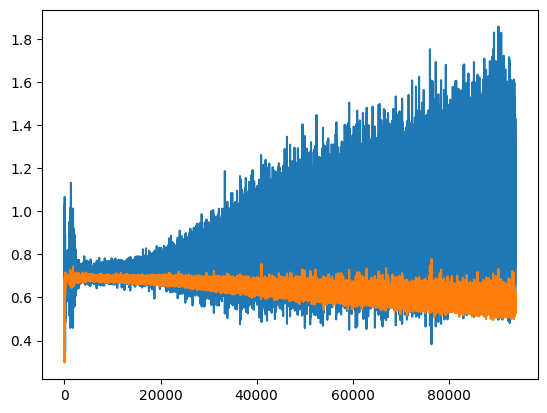

In [14]:
plt.plot(g_losses, label="g loss")
plt.plot(d_losses, label="d loss")
plt.show()

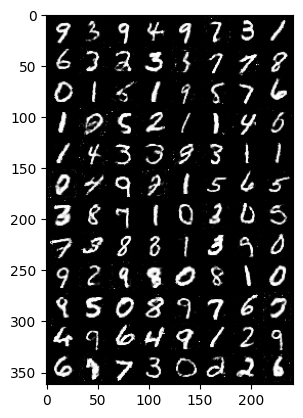

In [22]:
from skimage.io import imread
a = imread("gan_images/200.png")
plt.imshow(a)